# Timeline Extraction Using SpaCy and ChatGPT

This notebook contains the code for running the experiments conducted for the 'Timeline Extraction from Decision Letters Using ChatGPT' paper published in the 2024 CASE workshop proceedings. This notebook combines the SpaCy and ChatGPT scripts and also contains functionality for runnin the pipeline on raw text, performing the extraction and classification steps. Please also see the 'demo.ipynb' file for a demonstration of the pipeline on an example letter, with an example pipeline output picture. Please note that for the ChatGPT part of the experiments, an account for the ChatGPT API and a personal token are required.

## Index

1. [Dataloading](#dataloading)
2. [Data Exploration](#exploration)
3. [Spacy Date Extraction](#date_extraction)
4. [Spacy Evaluation](#spacy_evaluation)
5. [ChatGPT Event Extraction and Classification](#chatgpt)
6. [ChatGPT Evaluation](#chatgpt_evaluation)

## TODO
- Integrate the spacy date and request received date into the algorithm so that we can do the full 'document correct' calculation just in this notebook.
- Update the demo notebook so that we can have a nice demo in the repo as well.

<a id="dataloading"> <h1>Setup & Dataloading</h1></a>

First we load in the data for both the train and test sets, which has already been processed using spacy. The code to run this preprocessing step from spacy is located in the 'some_test_script.py' and can be run seperately as well.

In [206]:
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from glob import glob
from pprint import pprint
from datetime import datetime
from nltk import word_tokenize
from nltk.metrics import scores
import matplotlib.pyplot as plt
from torchmetrics.text.rouge import ROUGEScore
from scripts.remove_mistakes import remove_false_dates
from scripts.spacy_date_correction import compile, accuracy_dates, obtain_raw_spacy_output


# Set up openai and authorization key
from openai import OpenAI
my_openai_key = "REPLACE THIS WITH YOUR PERSONAL TOKEN"
client = OpenAI(api_key=my_openai_key)

"""Gets response of chatGPT using API"""
def get_completion(prompt, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [{"role": "user", "content": prompt}],
        timeout=10,
        temperature=0.0
)

    return response.choices[0].message.content

The code below can be used to extract the sentences with dates from raw text files using NLTK and SpaCy. This can take quite some time, so for this notebook we load the pre-generated files, but the code below can be uncommented to run the process yourself.

In [108]:
#obtain_raw_spacy_output('data/txt_files/train', 'data/results/uncorrected_spacy_output/uncorrected_dates_train.pkl')
#obtain_raw_spacy_output('data/txt_files/test', 'data/results/uncorrected_spacy_output/uncorrected_dates_test.pkl')

The original letters are first tokenized by NLTK so that we end up with a list of sentences for each letter, after which we extract dates using SpaCy and then remove false positives.

In [123]:
from scripts.decision import decision_class, evaluate_decision

# Our first step is to load the uncorrected dates from spacy, and correct them using the 
# 'date_correction' and 'remove_mistakes' scripts.
with open('data/uncorrected_spacy_output/uncorrected_dates_train.pkl', 'rb') as fp:
    train_uncorrected = pickle.load(fp)

with open('data/uncorrected_spacy_output/uncorrected_dates_test.pkl', 'rb') as fp:
    test_uncorrected = pickle.load(fp)

# Filter the false positives from SpaCy
train_corrected = compile(train_uncorrected)
test_corrected = compile(test_uncorrected)

# Also do the decision date classification here
train_corrected = decision_class(train_corrected)
test_corrected = decision_class(test_corrected)

# Load the annotated data with all the sentences that have dates and (possibly) events
all_train_triples = pd.read_csv('data/annotated_triples/train/date_event_combinations.csv')
all_test_triples = pd.read_csv('data/annotated_triples/test/date_event_combinations.csv')

The next step is to match up the corrected dataframe from spacy with the annotations, so that we also have the dates without events for the event extraction and classification phases.

<a id="date_extraction"><h2>Date Extraction</h2></a>

The above code returns the dates that have been corrected with the rulebased spacy date correction algorithm. Now we compare this with the triples that we have in `all_test_triples`, which have the corrected dates in them.


In [133]:
# Combine the spacy output with the annotated events.
def get_dates_without_event_df(complete_df, event_triple_df):
    no_event_df = []
    for _, row1 in complete_df.iterrows():
        if row1['sentence'] not in event_triple_df['sentence'].tolist():
            no_event_df.append(row1)
        
    no_event_df = pd.DataFrame(no_event_df)
    no_event_df['class'] = 'geen event'
    no_event_df['event'] = ''
    no_event_df = no_event_df[['doc_id', 'sentence', 'class', 'event', 'date']]
    triplets_df = event_triple_df[['doc_id', 'sentence', 'class', 'event', 'ISO_date']]
    triplets_df = triplets_df.rename({'ISO_date': 'date'}, axis=1)
    
    return pd.concat([no_event_df, triplets_df])

In [134]:
# Combine the train data with the rows with no events
train_data_all = get_dates_without_event_df(train_corrected, all_train_triples)
test_data_all = get_dates_without_event_df(test_corrected, all_test_triples)

In [77]:
# Load the ground truth dates
train_ground_truth = pd.read_csv('data/ground_truth_data/train_data_gt.csv', sep=';').fillna('geen event')
test_ground_truth = pd.read_csv('data/ground_truth_data/test_data_gt.csv', sep=';').fillna('geen event')

<a id="spacy_evaluation"><h2>Date Classification Evaluation</h2></a>

Next we will compare the ground truth dates with the predcted dates, where we parse the predicted dates to ISO format, which has not been done by SpaCy yet, but has been done for the annotated samples.

In [19]:
import locale
import datetime as datetime
locale.setlocale(locale.LC_TIME, "nl_NL")

converted_dates = pd.to_datetime(test_data_all['date'].iloc[:264], format='%d %B %Y', errors='coerce')
gt_dates = test_ground_truth['date'].iloc[:264]

In [20]:
correct_dates = (gt_dates.reset_index(drop=True) == converted_dates.reset_index(drop=True))

In [21]:
correct_dates = pd.concat([correct_dates, pd.Series([True for _ in range(524-264)])])

In [79]:
print("Out of the %d dates, %.2f percent was completely correct" % (correct_dates.shape[0], correct_dates.mean()*100))

Out of the 524 dates, 97.14 percent was completely correct


Next up, we will put this result in the groudn truth dataframe, so that we can later compare how often mistakes were made in complete documents. We will also filter uit the 'besluit datum' class and evaluate this seperately, as this is done using a rulebased approach, which we will evaluate below.

In [25]:
train_ground_truth['correct_date'] = ''
train_data = train_ground_truth[train_ground_truth['class'] != 'besluit datum']
test_ground_truth['correct_date'] = correct_dates.reset_index(drop=True)
test_data = test_ground_truth[test_ground_truth['class'] != 'besluit datum']


In [26]:
combined_data = pd.concat([train_data, test_data])

In [27]:
print("The train dataset contains a total of %d dates" % train_data_all.shape[0])
print("The test dataset contains a total of %d dates" % test_data_all.shape[0])

The train dataset contains a total of 423 dates
The test dataset contains a total of 524 dates


<a id="exploration"> <h1>Data Exploration</h1></a>

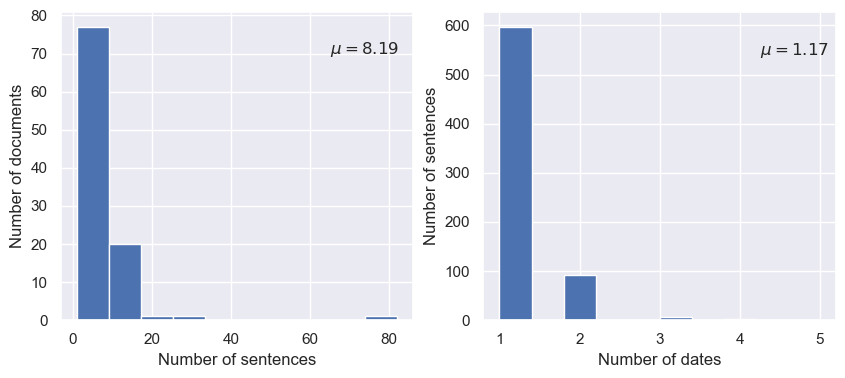

In [55]:
# set the sns grid style for plotting
sns.set(style="ticks")
sns.set_style("darkgrid")

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
combined_data.groupby('doc_id').size().plot(kind='hist', ax=axes[0])
combined_data.groupby('sentence').size().plot(kind='hist', ax=axes[1])
axes[0].set_xlabel("Number of sentences")
axes[0].set_ylabel("Number of documents")

axes[1].set_xlabel("Number of dates")
axes[1].set_ylabel("Number of sentences")

axes[0].text(65, 70, "$\mu=%.2f$" % combined_data.groupby('doc_id').size().mean())
axes[1].text(4.25, 540, "$\mu=%.2f$" % combined_data.groupby('sentence').size().mean())
#plt.tight_layout()
plt.savefig('images/mean_dataset_plots.eps', bbox_inches='tight')
plt.show()

We make a plot for the number of sentences in a document and the number of dates in a sentence over the combined dataset.

<a id="chatgpt"><h2>ChatGPT Event Extraction and Classification</h2>

The approach in the paper uses in-context learning for ChatGPT, where we extract the top-k most similar sentences from the training set for each example in the test set. We use BM25 for this, and use this both for the event classification as well as the event extraction.

In [156]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse


class BM25(object):
    def __init__(self, b=0.75, k1=1.6):
        self.vectorizer = TfidfVectorizer(norm=None, smooth_idf=False)
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """ Fit IDF to documents X """
        self.vectorizer.fit(X)
        y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = y.sum(1).mean()

    def transform(self, q, X):
        """ Calculate BM25 between query q and documents X """
        b, k1, avdl = self.b, self.k1, self.avdl

        # apply CountVectorizer
        X = super(TfidfVectorizer, self.vectorizer).transform(X)
        len_X = X.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        X = X.tocsc()[:, q.indices]
        denom = X + (k1 * (1 - b + b * len_X / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = X.multiply(np.broadcast_to(idf, X.shape)) * (k1 + 1)                                                          
        return (numer / denom).sum(1).A1


In [157]:
BM25_model = BM25()
BM25_model.fit(train_data['sentence'])

We use two prompts, the first one for the event extraction, and the second one for the event extraction. We experimented with doing both tasks in one go, but this decreased the overal performance of the pipelien.

In [158]:
def convert_dataframe_to_ground_truth_triples_test(dataframe):
    examples = []
    for row_id, row in dataframe.groupby('sentence'):
        input_sentence = row['sentence'].tolist()[0]
        ground_truth_triplets = [(date, event, event_class, date_correct) for _, (date, event, event_class, date_correct) in row[['date', 'event', 'class', 'correct_date']].iterrows()]
        examples.append({'input': input_sentence, 'output': ground_truth_triplets})
    return examples

In [159]:
def convert_dataframe_to_ground_truth_triples(dataframe):
    examples = []
    for row_id, row in dataframe.groupby('sentence'):
        input_sentence = row['sentence'].tolist()[0]
        ground_truth_triplets = [(date, event, event_class) for _, (date, event, event_class) in row[['date', 'event', 'class']].iterrows()]
        examples.append({'input': input_sentence, 'output': ground_truth_triplets})
    return examples

In [160]:
train_examples = convert_dataframe_to_ground_truth_triples(train_data)
test_examples = convert_dataframe_to_ground_truth_triples_test(test_data)

In [161]:
event_extraction_prompt = """
Je krijg een lijst met datums en een zin met deze datums erin.
Het is jouw taak om voor elke datum in de zin het de omschrijving van
de gebeurtenis op die datum te vinden. 

Je moet je output teruggeven als een lijst met tuples met voor elke datum de tekst die het event omschrijft of de datum met 'geen event' als er geen gebeurtenis plaatsvindt.
Hieronder enke voorbeelden
%s

voer deze taak nu uit op de volgende zin gegeven in 3 backticks

```%s```

"""

In [162]:
def run_event_extraction_prompt(test_dataframe, prompt, examples):
    outputs = []
    for row_id, row in tqdm(test_dataframe.groupby('sentence')):
        input_sentence = row['sentence'].tolist()[0]
        scores = np.argsort(BM25_model.transform(input_sentence, [item['input'] for item in examples]))[::-1]
        bm25_examples = [examples[score] for score in scores[:5]]
        
        example_strings = "\n"
        
        for string in bm25_examples:
            dates = [item[0] for item in string['output']]
            events = [item[1] for item in string['output']]
            example_strings+='datums: ' + str(dates) + '\n'
            example_strings+='input: ' + string['input'] + '\n'
            example_strings+='output: ' + str(list(zip(dates, events))) + '\n\n'

        ground_truth_triplets = [(date, event, event_class, correct_date) for _, (date, event, event_class, correct_date) in row[['date', 'event', 'class', 'correct_date']].iterrows()]
        input_dates = [triplet[0] for triplet in ground_truth_triplets]
        test_prompt = """
        datums: %s
        input: %s
        """ % (input_dates, input_sentence)
        
        output = get_completion(prompt=prompt % (example_strings, test_prompt))
        # Soms geef chatgpt wat meer terug, wij willen alleen onze lijst met triplets hebben
        try:
            corrected_output = eval(output[output.index('['): output.index(']')+1])
        except:
            print(output)
            corrected_output = [('', '', '')]
        outputs.append({'ground_truth': ground_truth_triplets, 'prediction': corrected_output})
    return outputs

In [163]:
test_documents = test_data.groupby('doc_id')
event_extraction_output = []

In [164]:
for document in tqdm(test_documents):
    event_extraction_output.append(run_event_extraction_prompt(document[1], event_extraction_prompt, train_examples))

 50%|███████████████████████▌                       | 3/6 [00:03<00:03,  1.03s/it]


 47%|█████████████████████▎                       | 26/55 [00:26<00:24,  1.17it/s]


 54%|████████████████████████▎                    | 27/50 [04:25<03:44,  9.75s/it]


 18%|████████▎                                     | 2/11 [00:02<00:10,  1.13s/it]


  8%|███▊                                          | 1/12 [00:00<00:10,  1.10it/s]


100%|█████████████████████████████████████████████| 50/50 [07:49<00:00,  9.38s/it]


In [165]:
## Second prompt, classify based on the event extractor
event_classification_prompt = """
Je krijg een lijst met zinnen en het is jouw taak om elk van de zinnen te classificeren in 1 van de volgende klasses.
1. "verzoek datum" = Op deze datum is een Woo verzoek ingediend. Op deze datum is er verzocht om informatie doormiddel van een Woo-verzoek. Op deze datum is gevraagd om openbaarmkaing van informatie. 
2. "verzoek ontvangen" = Op deze datum is een Woo verzoek ontvangen. 
3. "ontvangst verzoek bevestigd" = Op deze datum is bevestigd dat het verzoek ontvangen is. 
4. "beslistermijn verdaagd" = Op deze datum is de beslistermijn verdaagd, verplaatst of verlengd.
5. "inwerking treden van Woo" = Op 1 mei 2020 is de Woo inwerking getreden. Op 1 mei 2020 is de Wob vervangen door de Woo.
6. "contact" = Op deze datum heeft er communicatie plaatsgevonden.
7. "overig" = Als een datum niet onder een van de andere klassen valt.
8. "geen event" = De datum in de zin is niet verbonden aan een van de bovengenoemde klasses.

Je moet je output teruggeven als een lijst van klasses met 1 element voor elke zin in de input, zoals in de volgende voorbeelden:
%s

voer deze taak nu uit op de volgende zin gegeven in 3 backticks

```%s```

"""

For the event classification, we use a separate BM25 model, fitted on the event phrases from the training set.

In [166]:
event_BM25_model = BM25()
event_BM25_model.fit(train_data['event'])

In [167]:
def run_event_classification_prompt(first_stage_output, prompt, examples):
    outputs = []
    train_examples = []
    
    for sentence in tqdm(first_stage_output):
        events = [item[1] for item in sentence['ground_truth']]

        example_strings = "\n"
        
        for event in events:
            scores = np.argsort(event_BM25_model.transform(event, train_data['event']))[::-1]
            bm25_examples = [(train_data['event'].iloc[score], train_data['class'].iloc[score]) for score in scores[:3]]
            for event_example in bm25_examples:
                example_strings+="""
                input: ['%s']
                output: ['%s']
                """ % (event_example[0], event_example[1])
        input_events = [item[1] for item in sentence['ground_truth']]
        classes = [item[2] for item in sentence['ground_truth']]
        
        test_prompt = """
        input: %s
        """ % (str(input_events))
        output = get_completion(prompt=prompt % (example_strings, test_prompt))
        # Soms geef chatgpt wat meer terug, wij willen alleen onze lijst met triplets hebben
        try:
            corrected_output = eval(output[output.index('['): output.index(']')+1])
        except:
            print('something has gone wrong')
            print(output)
            corrected_output = ['']
        sentence['classes'] = corrected_output
        outputs.append(sentence)
    return outputs

In [168]:
test_docs = [document['doc_id'].unique()[0] for _, document in test_documents]

In [169]:
event_classification_output = []

In [170]:
for document in tqdm(event_extraction_output):
    event_classification_output.append(run_event_classification_prompt(document, event_classification_prompt, train_examples))

 50%|███████████████████████▌                       | 3/6 [00:02<00:02,  1.44it/s]


 47%|█████████████████████▎                       | 26/55 [00:17<00:21,  1.38it/s]


 54%|████████████████████████▎                    | 27/50 [02:25<02:10,  5.68s/it]


 18%|████████▎                                     | 2/11 [00:01<00:06,  1.39it/s]


  8%|███▊                                          | 1/12 [00:00<00:05,  1.99it/s]


100%|█████████████████████████████████████████████| 50/50 [04:18<00:00,  5.18s/it]


<a id="chatgpt_evaluation"><h2>ChatGPT Evaluation</h2></a>

Below we will evaluate the output from both the event extraction as well as the event classification parts of the pipeline, using p, r and f1 scores for the classification, and the ROUGEL-F1 score for the event extraction.

In [196]:
# Initialize the rouge metric
rouge = ROUGEScore(use_stemmer=True, tokenizer=word_tokenize)
correct_events = 0
correct_classes = 0
correct_triples = 0
total_pairs = 0
ground_truth_classes = []
predicted_classes = []

completely_correct_docs = 0
not_correct = []


raw_rouge_scores = []

for k, document in enumerate(event_classification_output):
    correct_triples_in_doc = 0
    num_pairs = 0
    for sentence in document:
        num_pairs+=len(sentence['ground_truth'])
        if len(sentence['ground_truth']) == len(sentence['prediction']) == len(sentence['classes']):
            total_pairs+=len(sentence['ground_truth'])
            for i in range(len(sentence['ground_truth'])):
                date_correct = sentence['ground_truth'][i][-1]
                rouge_score = rouge(sentence['prediction'][i][1], sentence['ground_truth'][i][1])['rougeL_fmeasure']
                raw_rouge_scores.append(rouge_score.item())
                if rouge_score > 0.50:
                    event_correct=True
                    correct_events+=1
                else:
                    event_correct = False
                ground_truth_classes.append(sentence['ground_truth'][i][2])
                predicted_classes.append(sentence['classes'][i])
                if sentence['ground_truth'][i][2] == sentence['classes'][i]:
                    correct_classes+=1
                    class_correct = True
                else:
                    class_correct = False
                if class_correct and event_correct and date_correct:
                    correct_triples+=1
                    correct_triples_in_doc+=1
    if correct_triples_in_doc == num_pairs:
        completely_correct_docs+=1
    else:
        not_correct.append(abs(num_pairs-correct_triples_in_doc))
            

In [197]:
print("The total number of correct triples is %d, which is %.2f percent of the total" % (correct_triples, (correct_triples/total_pairs)*100))

The total number of correct triples is 346, which is 76.04 percent of the total


In [198]:
print("Out of the %d documents, %d were completely correct" % (50, completely_correct_docs))

Out of the 50 documents, 10 were completely correct


Apart from the triple and document scores, we also look at the rouge scores for the extraction the clasification report for the classification in more detail.

In [199]:
rouge_series = pd.Series(raw_rouge_scores)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


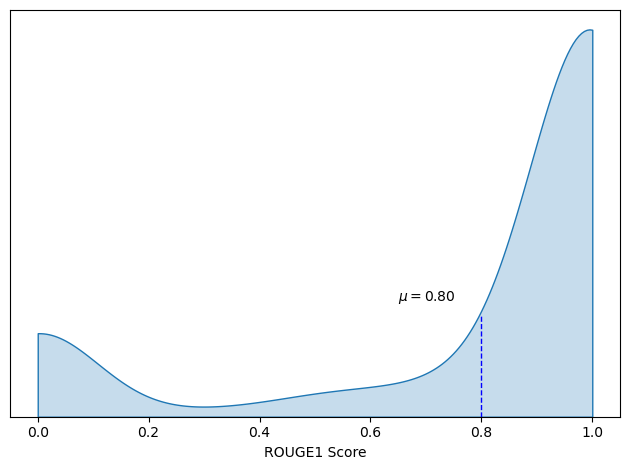

In [200]:
import seaborn as sns
sns.kdeplot(rouge_series, fill=True, clip=[0, 1])
plt.axvline(x=rouge_series.mean(), color='blue', linestyle='--', linewidth=1, ymax=0.25)
plt.text(0.65, 0.8, "$\mu=%.2f$" % rouge_series.mean())
plt.xlabel("ROUGE1 Score")
plt.yticks([])
plt.ylabel("")
plt.tight_layout()
plt.savefig("ROUGE1_plot.eps")
plt.show()

Next we create two series from the predictions from ChatGPT, and evaluate using the `classification_report` from sklearn.

In [203]:
new_gt = []
new_pred = []

for i in range(len(ground_truth_classes)):
    if not ground_truth_classes[i] == 'geen event':
        new_gt.append(ground_truth_classes[i])
        new_pred.append(predicted_classes[i])

In [204]:
import sklearn

In [205]:
event_classification = sklearn.metrics.classification_report(new_gt, new_pred, output_dict=True)
print(pd.DataFrame(event_classification).transpose().round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
beslistermijn verdaagd      &       0.90 &    0.93 &      0.92 &     29.0 \\
contact                     &       0.89 &    0.79 &      0.84 &     42.0 \\
geen event                  &       0.00 &    0.00 &      0.00 &      0.0 \\
inwerking treden van Woo    &       1.00 &    1.00 &      1.00 &     16.0 \\
ontvangst verzoek bevestigd &       1.00 &    0.98 &      0.99 &     44.0 \\
overig                      &       0.75 &    0.62 &      0.68 &     24.0 \\
verzoek datum               &       0.94 &    0.98 &      0.96 &     47.0 \\
verzoek ontvangen           &       0.74 &    1.00 &      0.85 &     14.0 \\
accuracy                    &       0.90 &    0.90 &      0.90 &      0.9 \\
macro avg                   &       0.78 &    0.79 &      0.78 &    216.0 \\
weighted avg                &       0.91 &    0.90 &      0.90 &    216.0 \\
\bottomrule
\end{tabular}



/Users/rubenvanheusden/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rubenvanheusden/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rubenvanheusden/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/1l/3m50rd